In [1]:
from utils import load_display_options, ignore_warnings
load_display_options()
ignore_warnings()

In [2]:
from visualisation.visualise import load_fonts, load_mpl_style
visualisation_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/src/visualisation"
font_path = visualisation_path + "/fonts"
# style_path = visualisation_path + "/mplstyle/lilac_pitch_clusters.mplstyle"

load_fonts(font_path)
# load_mpl_style(style_path)

In [3]:
import pandas as pd
import seaborn as sns
from clustering.clustering import GMM

Load Chain Data

In [4]:
chains = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-playing-styles/data/playing_style_chains_v2.csv")
match_id = "2022F4_Geelong_Sydney"
team = "Geelong"

Get Plot Data

In [5]:
from chain_utils import get_match, get_team

In [6]:
def get_defensive50s(chains):
    
    start_in_defensive50 = ((chains['left_right_start_x'] - (-chains['Venue_Length']/2))**2 + (chains['left_right_start_y'])**2)**0.5 < 50
    end_out_defensive50 = ((chains['left_right_end_x'] - (-chains['Venue_Length']/2))**2 + (chains['left_right_end_y'])**2)**0.5 > 50
    
    return chains[start_in_defensive50 & end_out_defensive50 & (chains['Disposal'] == "effective")]

In [7]:
def get_defensive50_data(chains, match_id, team):
    
    match_chains = get_match(chains, match_id=match_id)
    team_chains = get_team(match_chains, team=team)
    defensive50s = get_defensive50s(team_chains)
        
    return defensive50s

In [8]:
clusters = 10
cluster_variables = ['left_right_start_x', 'left_right_start_y', 'left_right_end_x', 'left_right_end_y']

In [9]:
defensive50s = get_defensive50_data(chains, match_id=match_id, team=team)
defensive50s['GMM_'+str(clusters)] = GMM(clusters=clusters, data=defensive50s[cluster_variables])

In [10]:
def create_defensive50_plot_data(chains, match_id, team, clusters, cluster_variables):
    
    defensive50s = get_defensive50_data(chains, match_id=match_id, team=team)
    defensive50s['GMM_'+str(clusters)] = GMM(clusters=clusters, data=defensive50s[cluster_variables])
    
    return defensive50s

Plot Clusters on Pitch

In [11]:
from visualisation.plotting_pitches import plot_vertical_pitch_ax
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def plot_arrows_clusters_pitch_ax(pitch, ax, data, start_xy, end_xy, colour_cycle, label = "label", top_n = 3):
                
    for rank in np.linspace(0, top_n-1, top_n):
        cluster = data[label].value_counts().index[rank]     
        clustered = data.loc[data[label] == cluster]
        pitch.arrows(clustered[start_xy[0]], clustered[start_xy[1]], clustered[end_xy[0]], clustered[end_xy[1]], color = colour_cycle[int(rank)], ax=ax, 
                     width=1, vertical = True)
    
    return pitch, ax

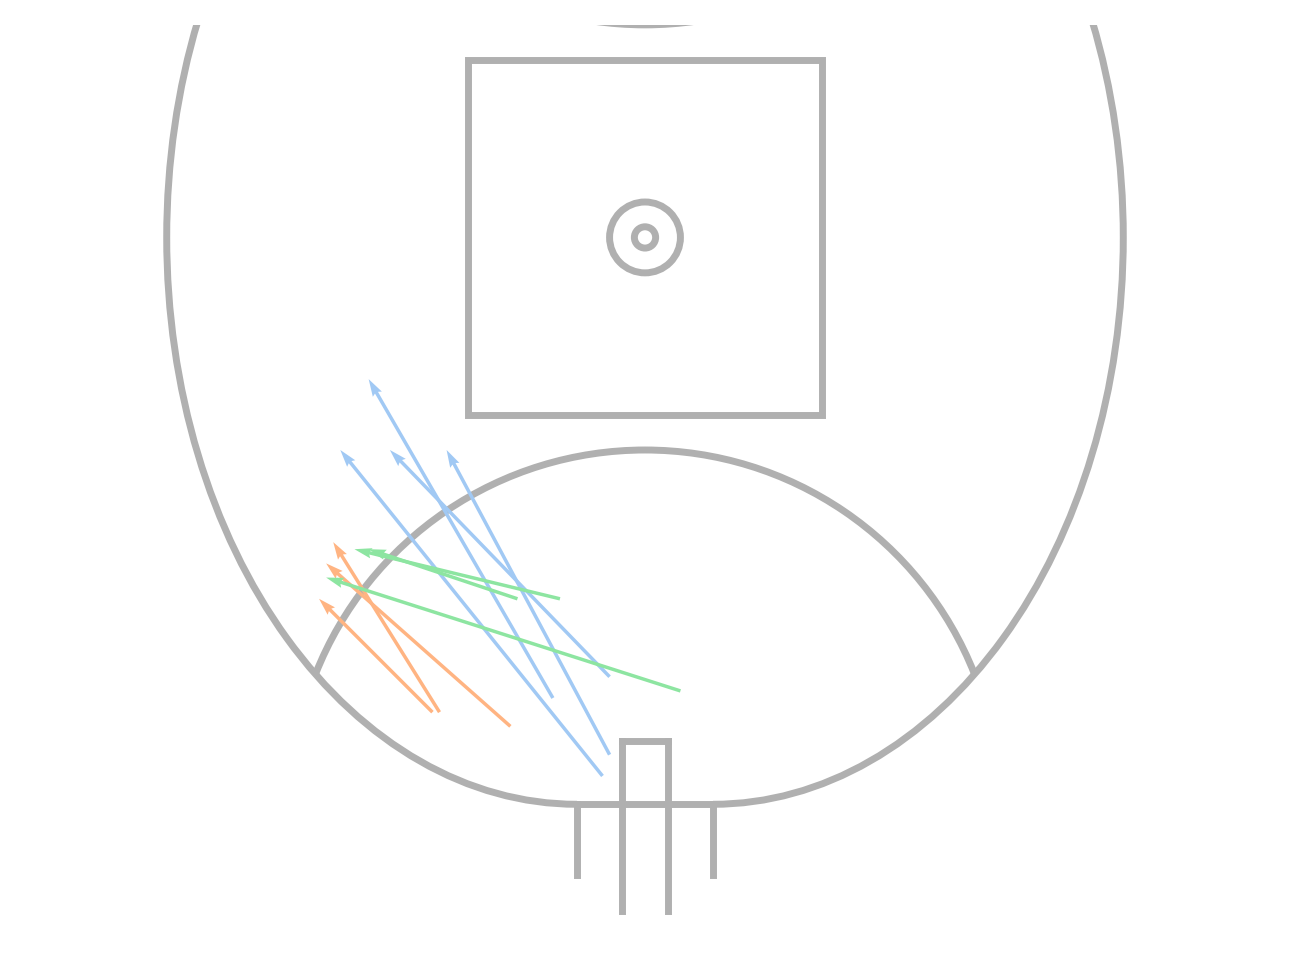

In [13]:
fig, ax = plt.subplots()
fig.dpi = 250
pitch, ax = plot_vertical_pitch_ax(ax, pad_top=-50)
pitch, ax = plot_arrows_clusters_pitch_ax(pitch, ax,
                                          data=defensive50s, 
                                          start_xy=('left_right_start_x', 'left_right_start_y'),
                                          end_xy = ('left_right_end_x', 'left_right_end_y'),
                                          colour_cycle=sns.color_palette("pastel", clusters),
                                          label='GMM_10', top_n=3)